In [1]:
#Import all necessary packages.
%matplotlib inline
import sys, platform, os

from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower

import pylab as pl

import scipy
from scipy.interpolate import interp1d
#from __future__ import division

from scipy import integrate
from scipy import linalg
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.0.10 installed at /local/home/scasas/anaconda2/envs/py37/lib/python3.7/site-packages/camb-1.0.10-py3.7.egg/camb


In [2]:
# para obtener ayuda, usar: camb.CAMBparams?

In [3]:
#Fiducial cosmological parameters
c=3e5
pi=np.pi
## omegac =~ 0.25
## omegab =~ 0.05
h=0.678
omegab=0.05  ## pasar a camb: omegab*h^2
omegac=0.24   ## pasar a camb: omegac*h^2
omegam=omegac+omegab

In [4]:
class CAMBresults:
    def __init__(self, redshifts=[0.], **kwargs):
        H0 = kwargs['H0']
        ombh2 = kwargs['ombh2']
        omch2 = kwargs['omch2']
        mnu = kwargs['mnu']
        w = kwargs['w']
        wa = kwargs['wa']
        As = kwargs['As']
        ns = kwargs['ns']
        kmax = kwargs['kmax']
        halofit_formula = kwargs.get('halofit_formula', 'takahashi')
        nonlinear = kwargs.get('nonlinear', True)
        #print(halofit_formula)
        self.pars = camb.CAMBparams()
        self.kmax = kmax
        self.pars.set_cosmology( H0 = H0, ombh2 = ombh2, omch2 = omch2, mnu = mnu)
        self.pars.set_dark_energy(w = w, wa = wa)
        #print(self.pars)
        self.pars.InitPower.set_params(As = As, ns = ns)
        self.results = camb.get_results(self.pars)
        self.pars.set_matter_power(redshifts = redshifts, kmax = kmax)
        if nonlinear==True:
            self.pars.NonLinear = model.NonLinear_both
            self.pars.NonLinearModel.set_params(halofit_version = halofit_formula)
        else:
            self.pars.NonLinear = model.NonLinear_none
        
        self.results.calc_power_spectra(self.pars)        

    def interpolate_power_spec(self):
        values = self.results.get_matter_power_spectrum(minkh = 1e-4, maxkh = self.kmax, npoints = 500)
        self.kh, self.z, self.pk = values
        self.PK_of_z = [interp1d(self.kh, pkz) for pkz in self.pk]
        print("shape of k array: ", self.kh.shape)
        print("shape of Pk array: ", self.pk.shape)
        #self.PK = camb.get_matter_power_interpolator(self.pars, hubble_units = False, k_hunit = True, log_interp = False)
        return None
    def power_spec(self, z_ind, k):
        pkz = self.PK_of_z[z_ind](k)
        return pkz

In [64]:
eps=0.01

In [67]:
cosmologia1 = CAMBresults(redshifts=[0., 1., 2.] , H0=h*(1-eps)*100, 
                      ombh2=omegab*(h**2), omch2 = omegac*(h**2), 
                      mnu = 0.0, w =-1, wa =0, As = 2.14e-9, ns = 0.968, kmax=10)

Note: redshifts have been re-sorted (earliest first)


In [66]:
cosmologia2 = CAMBresults(redshifts=[0., 1., 2.] , H0=h*(1+eps)*100, 
                      ombh2=omegab*(h**2), omch2 = omegac*(h**2), 
                      mnu = 0.0, w =-1, wa =0, As = 2.14e-9, ns = 0.968, kmax=10, nonlinear=False)

Note: redshifts have been re-sorted (earliest first)


In [43]:
#cosmologia1.results.get_matter_power_spectrum?

In [44]:
cosmologia1.interpolate_power_spec()

shape of k array:  (500,)
shape of Pk array:  (3, 500)


In [45]:
cosmologia2.interpolate_power_spec()

shape of k array:  (500,)
shape of Pk array:  (3, 500)


In [46]:
print(cosmologia1.PK_of_z[0](0.5) )  #nonlinear
print(cosmologia2.PK_of_z[0](0.5) )   #linear

704.8356514321188
279.68023432996137


z =  0.0
z =  1.0
z =  2.0


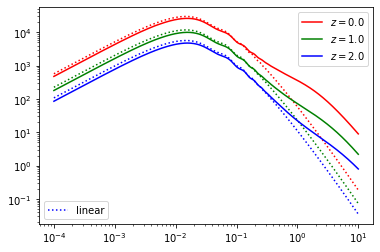

In [47]:
collist = ['r', 'g', 'b']
lineslist = []
for ii,zz in enumerate(cosmologia1.z):
    print("z = ", zz)
    line1, = plt.loglog(cosmologia1.kh, cosmologia1.PK_of_z[ii](cosmologia1.kh),
               '-', color=collist[ii], label='$z=$'+str(zz))
    lineslist.append(line1)
    
    line2,  = plt.loglog(cosmologia2.kh, cosmologia2.PK_of_z[ii](cosmologia2.kh),
               ':', color=collist[ii], label='linear')
    #plt.legend()
first_legend = plt.legend(handles=lineslist, loc='upper right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2], loc='lower left')
#plt.loglog(cosmologia1.kh, cosmologia1.PK(0.0, cosmologia1.kh).flatten(), '-.', color='green')  #no funciona

#plt.loglog(cosmologia1.kh, cosmologia1.pk[0] , ':', color='blue')  # directamente el kh y Pgrid

In [48]:
cosmologia1.results.hubble_parameter(0.5)

88.11704182525625

In [57]:
cosmologia1.pars.z_outputs

array([], dtype=float64)

In [50]:
class CosmoFunctions:
    """Obtain Hubble function
        Parameter:
            H0: Hubble constant"""
    def __init__(self, CAMBresults, **kwargs):
        self.H0 = CAMBresults.pars.H0
        self.hubble_parameter = CAMBresults.results.hubble_parameter
        self.omegab =  CAMBresults...omegab  #ejemplo
        self.gamma = kwargs.get('gamma', 0.55)  #ejemplo

    def E_z(self, z):
        """E(z)
            Parameters:
                z: Redshift
                Notes: H(z) in km/s/Mpc while CAMB's H(z) is in 1/Mpc"""
        resu = self.hubble_parameter(z)/self.H0
        return resu

In [51]:
hubble1 = Hubble(cosmologia1)
print('H0:', hubble1.H0)

H0: 67.80000000000001


In [53]:
print('H0:', Hubble(cosmologia2).H0)

H0: 72.0


In [55]:
Hubble(cosmologia2).E_z([2.3,3.4])

array([3.16127512, 4.76218162])

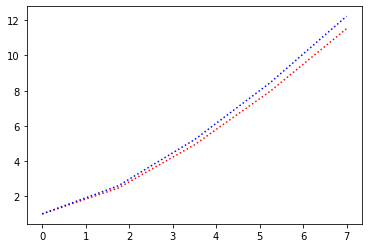

In [56]:
zz = np.linspace(0.,7., 5)
plt.plot(zz, Hubble(cosmologia2).E_z(zz), ':', color='red')
plt.plot(zz, Hubble(cosmologia1).E_z(zz), ':', color='b')

In [ ]:
class ComovingDistance(Hubble):
    """Comvoing Distance
        Parameters:
            H0: Hubble constant"""
    def __init__(self, H0, h_z):
        super().__init__(H0, h_z)
        self.r_z_vec = np.vectorize(self.rcom)

    def rcom_prime(self, z): #this is the one used for results
        return self.r_z_vec(z)/(constants.c/self.H0)
       self.drdz = (constants.c/self.H0)/self.E_z(z)  #define atributo que solo va a usar aqui en esta clase

    def rcom(self, z):
        return integrate.romberg(self.drdz, 0., z)

prueba7 = ComovingDistance(0.67, 10)
print('Comoving Distance:', prueba7.rcom_prime(4))

In [58]:
"""Defino el factor de crecimiento"""

class growthFactor(Hubble):
    """Growth Factor
        Parameters:
            Omega_0:  
            z: redshift
            Gamma: """
    def __init__(self,  CAMBresults  """" seguir aqui """"):
        super().__init__(H0, h_z)
        self.omega0 = omega0
        self.gamma = gamma

    def growthFunction(self, z):
        value1 = self.E_z(z)
        value2 = self.omega0*pow((1 + z), 3)
        value3 = pow(value2/value1, self.gamma)
        return value3

    def dgF_dz(self, z):
        return (self.growthFunction(z))/(1 + z)

    def Growth_Factor(self, z):
        return np.exp(integrate.romberg(self.dgF_dz, 0., z))

prueba3 = growthFactor(0.67, 10, 10, 2)
print("Growth Factor:", prueba3.Growth_Factor(4))

SyntaxError: invalid syntax (<ipython-input-58-330174f47782>, line 9)

In [ ]:
"""Obtengo la temperatura que se utiliza en la ecuación del PHI"""

class Temperature(Hubble): #obtaining the temperature (T^2(z)) for the Power Spectrum (PHI(z))
    def __init__(self, H0, h_z, densityHI):
        super().__init__(H0, h_z)
        self.densityHI = densityHI
    
    def omega_HI(self, z):
        return (8*np.pi*constants.G*self.densityHI)/(3*(self.H0**2))
    
    def Temp_obs(self, z):
        return 44e-6*(self.omega_HI(z)*((self.H0/100)/2.45e-4)*((1 + z)**2))/self.E_z(z)

prueba4 = Temperature(0.67, 10, 0.5)
print('Temperature:', prueba4.Temp_obs(2))

In [ ]:
"""Con las clases anteriores, ya se puede obtener el Power Spectrum
    No lo inicialicé por el problema que está dando en la clase de CAMB
    Fíjese en la definición de matterPowerSpectrum como estoy llamando el PK de camb
    No estoy seguro de que sea la forma correcta. Tal vez me pueda aclarar eso un poco.
    Estoy viendo cómo utilizar una lista de datos como argumento en las definiciones,
    para no tener que poner tantos argumentos."""

class HIPowerSpectrum:
    def __init__(self, H0, ombh2, omch2, mnu, w0, wa, As, ns, kmax, redshifts, h_z, densityHI, omega0, gamma, bias):
        self.camb = CAMBresults(H0, ombh2, omch2, mnu, w0, wa, As, ns, kmax, redshifts)
        self.temperature = Temperature(H0, h_z, densityHI)
        self.growth_factor = growthFactor(H0, h_z, omega0, gamma)
        self.bias = bias
        
    def matterPowerSpectrum(self, z):
        return (self.growth_factor.Growth_Factor(z)**2)*self.camb.PK
    
    def HIPowerSpectrum(self, z):
        return (self.temperature.Temp_obs(z)**2)*(self.bias**2)*(self.matterPowerSpectrum(z)**2)

#prueba5

PHI = b^2 * P


In [ ]:
"""A partir de aquí empiezo a obtener los valores necesarios para la Matriz de Fisher"""

class sigmaPix:
    def __init__(self, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys):
        #alist = []
        self.Ddish = Ddish
        self.delta_f = delta_f
        self.ttotal = ttotal
        self.omegaTot = omegaTot
        self.Ndishes = Ndishes
        self.Nbeams = Nbeams
        self.Tsys = Tsys
    
    def theta_B(self, z):
        return 21*(1 + z)/self.Ddish
    
    def Omega_Pix(self, z):
        return 1.31*(self.theta_B(z))**2
        
    def sigma_Pix(self, z):
        return self.Tsys/np.sqrt(self.delta_f*self.ttotal*(self.Omega_Pix(z)/self.omegaTot)*self.Ndishes*self.Nbeams)

prueba6 = sigmaPix(13, 1, 2, 3, 4, 1, 21.1e3)
print("sigma_Pix:", prueba6.sigma_Pix(2))

In [ ]:
"""Me estoy guiando en el código de Alkistis para obtener el zmin y zmax.
    Es raro porque esos valores de Dzbin, dfpix y midfreq son valores que en ningún otro lado
    aparecen más que en el código."""


class V_pix(CosmoFunctions):
    def __init__(self, H0, h_z, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys, Dzbin, dfpix, midfreq):
        super().__init__(H0, h_z)
        self._sigmaPix = sigmaPix(Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys)
        self.Dzbin = Dzbin
        self.dfpix = dfpix
        self.midfreq = midfreq
        
    def dV_pixdz(self, z):
        return constants.c*(self.rcom_prime(z)**2)/(100*self.H0*self.E_z(z))
    
    def dzpix(self, z): #it is used to obtain the zmin and zmax for integration.
        return ((1 + z)**2)*self.dfpix/self.midfreq
    
    def zmax(self, z):
        return z + self.dzpix(z)/2
    
    def zmin(self, z):
        return z - self.dzpix(z)/2
    
    def Vpix(self, z):
        return self._sigmaPix.sigma_Pix(z)*(integrate.romberg(self.dV_pixdz, self.zmin(z), self.zmax(z)))

prueba8 = V_pix(0.67, 10, 13, 1, 2, 3, 4, 1, 21.1e3, 0.1, 50e3, 14204e6)
print("V_pix:", prueba8.Vpix(2))

In [ ]:
class Wsquared(ComovingDistance, sigmaPix):
    def __init__(self, H0, h_z, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys):
        ComovingDistance.__init__(self, H0, h_z)
        sigmaPix.__init__(self, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys)
    
    def Wsq(self, k, z):
        return np.exp(-1*(k**2)*self.rcom_prime(z)**2*(self.theta_B(z)/np.sqrt(8*np.log(2))))

prueba9 = Wsquared(0.67, 0.1, 13, 0.14, 4000, 3, 4, 1, 21.1e3)
print("W^2:", prueba9.Wsq(1.07, 2))

In [ ]:
class PNoise:
    def __init__(self, H0, h_z, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys, Dzbin, dfpix, midfreq):
        self._sigmaPix = sigmaPix(Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys)
        self._V_pix = V_pix(H0, h_z, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys, Dzbin, dfpix, midfreq)
        self._Wsquared = Wsquared(H0, h_z, Ddish, delta_f, ttotal, omegaTot, Ndishes, Nbeams, Tsys)
        
    def P_Noise(self, k, z):
        return (self._sigmaPix.sigma_Pix(z)**2)*(self._V_pix.Vpix(z))*(self._Wsquared.Wsq(k, z)**-2)

prueba10 = PNoise(0.67, 0.1, 13, 0.14, 4000, 3, 4, 1, 21.1e3, 0.1, 50e3, 14204e6)
print("P_Noise", prueba10.P_Noise(0.1, 2))

In [ ]:
"""Aquí estoy poniendo como argumento el sigmaSur que es el sigma del Survey específico,
    pero en el código de Alkistis no lo toman en cuenta, me parece."""


class V_survey(ComovingDistance):
    def __init__(self, H0, h_z, sigmaSur, Dzbin):
        super().__init__(H0, h_z)
        self.sigmaSur = sigmaSur
        self.Dzbin = Dzbin
        
    def dV_surdz(self, z):
        return constants.c*(self.rcom_prime(z)**2)/(100*self.H0*self.E_z(z))
    
    def zmax(self, z):
        return z + self.Dzbin/2
    
    def zmin(self, z):
        return z - self.Dzbin/2
    
    def Vsur(self, z):
        return self.sigmaSur*(integrate.romberg(self.dV_surdz, self.zmin(z), self.zmax(z)))

prueba8 = V_survey(0.67, 10, 0.53, 0.1)
print("V_sur:", prueba8.Vsur(2))

In [ ]:
"""Esto es para la integral de la matriz de Fisher más adelante."""

""" No es necesario hacer clase de esto!!!                     """

class kminmax(ComovingDistance):
    def __init__(self, H0, h_z, omegaTot, ns):
        super().__init__(H0, h_z)
        self.omegaTot = omegaTot
        self.ns = ns
    
    def kmin(self, z):
        return 2*np.pi/np.sqrt((self.rcom_prime(z)**2)*self.omegaTot)
    
    def kmax(self, z):
        return 0.14*pow((1 + z),(2/(2 + self.ns)))
        
prueba12 = kminmax(0.67, 0.1, 0.53, 1)
print("k_min:", prueba12.kmin(2))
print("k_max:", prueba12.kmax(2))

In [61]:
class Star:
    
    def __init__(self, mag):
        self.mag = mag
        
class Galaxy:
    
    def __init__(self, mass):
        self.mass = mass
    
class Cluster:
    
    def __init__(self, star, galaxy):
        self.star = star
        self.galaxy = galaxy
        self.mag = star.mag
        self.mass = galaxy.mass
        self.luminosity = self.mag*self.mass

In [63]:
star = Star(11.)
galaxy = Galaxy(10.)
inst = Cluster(star, galaxy)
print("mag =", inst.mag)
print("mass =", inst.mass)
print("lum =", inst.luminosity)
inst2 = Cluster(Star(5.), Galaxy(20.))
print("mag =", inst2.mag)
print("mass =", inst2.mass)
print("lum =", inst2.luminosity)

mag = 11.0
mass = 10.0
lum = 110.0
mag = 5.0
mass = 20.0
lum = 100.0
